# **Quantitative 3D Analysis of the Equine Placenta Using Intensity-Based Image Segmentation**

This project applies **intensity-based image segmentation** using open-source Python tools to a high-resolution **micro-CT dataset of the equine placenta** (363 × 3132 × 2076 voxels; voxel size = 86 μm) to extract quantitative volumetric metrics of major tissue compartments.


**The image dataset used was downloaded at Bioimage Archive accession S-BIAD1130 under license CC BY 4.0**
**https://www.ebi.ac.uk/biostudies/bioimages/studies/S-BIAD1130. Dataset was previously dowloaded and uploaded to Google drive.**

 **This work is inspired by the study conducted by D. Laundon et al (2024)(https://doi.org/10.1016/j.placenta.2024.07.313).**


In [ ]:
!pip install tifffile scikit-image matplotlib plotly numpy

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology
import plotly.graph_objects as go
import os


**Loading image data from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from skimage import io
image = io.imread("/content/drive/MyDrive/Pony_Placenta_microCT.tif")


**The image datashape is inspected to describe the dimension of the dataset.**

**It reads the number of image slices, number of pixels per row and number of pixels per column.**

In [ ]:
image=tiff.imread("/content/drive/MyDrive/Pony_Placenta_microCT.tif")
print("Data shape:", image.shape)

Data shape: (363, 3132, 2076)


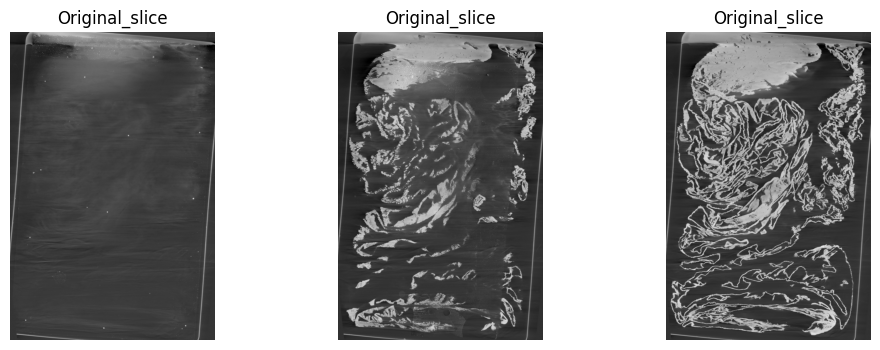

In [ ]:
fig, axes= plt.subplots(1,3, figsize=(12,4))
for i, ax in enumerate(axes):
  ax.imshow(image[i*20], cmap="gray")
  ax.set_title('Original_slice')
  ax.axis('off')
plt.show()


**I used Multi-Otsu thresholding to separate an image slice into regions of distinct attenuation levels. These regions represent differences in tissue density**

**Thresholding was done in 5 classes (Background, Low intensity, Intermediate intensity, Moderate intensity and highest intensity)**

In [ ]:

slice_idx = 100
global_thresholds = threshold_multiotsu(image[slice_idx], classes=5)
print("Global thresholds:", global_thresholds)

Global thresholds: [ 55  90 133 166]


In [ ]:
segmented_volume = np.zeros_like(image, dtype=np.uint8)

# Multi-class segmentation
for i in range(image.shape[0]):
    thresholds = threshold_multiotsu(image[i], classes=5)
    segmented_volume[i] = np.digitize(image[i], bins=thresholds)
    if (i + 1) % 50 == 0:
        print(f"Segmented slice {i+1}/{image.shape[0]}")

print("✅ Multi-class segmentation done!")


**To enhance visual interpretation, each intensity class is assigned a unique colour.**

Background- Black

Low intensity-Grey

Intermediate intensity- Blue

Moderate intensity- Green

highest intensity- White


In [ ]:
from skimage import color
import numpy as np
import tifffile as tiff


#Colour labels

custom_colors = ['gray', 'blue', 'green', 'white']
out_folder = "/content/drive/MyDrive/Placenta_GlobalColorSlices/"
os.makedirs(out_folder, exist_ok=True)

for i in range(segmented_volume.shape[0]):
    seg_color = color.label2rgb(
        segmented_volume[i],
        colors=custom_colors,
        bg_label=0,
        bg_color='black'
    )
    tiff.imwrite(f"{out_folder}/slice_{i:03d}.tif", (seg_color * 255).astype(np.uint8))
    if (i + 1) % 50 == 0:
        print(f"Processed {i+1}/{segmented_volume.shape[0]} slices")

print("✅ Saved all globally-coloured slices to:", out_folder)


Processed 50/363 slices
Processed 100/363 slices
Processed 150/363 slices
Processed 200/363 slices
Processed 250/363 slices
Processed 300/363 slices
Processed 350/363 slices
✅ Saved all globally-coloured slices to: /content/drive/MyDrive/Placenta_GlobalColorSlices/


**Selected Image slices are displayed.**



**Because this segmentation is purely intensity-based, the classes are interpreted as density groups rather than explicit anatomical parts.**

In comparison with the reference dataset by Laundon et al. (2024), the high-intensity regions (white) likely represent the outer chorionic plate.

The moderate-intensity regions (green) appear to correspond to the amniotic sac, while the intermediate-intensity regions (blue) may reflect vascular structures and the allantoic pouches.

Finally, the low-intensity regions (grey) are interpreted as allantoic regions.

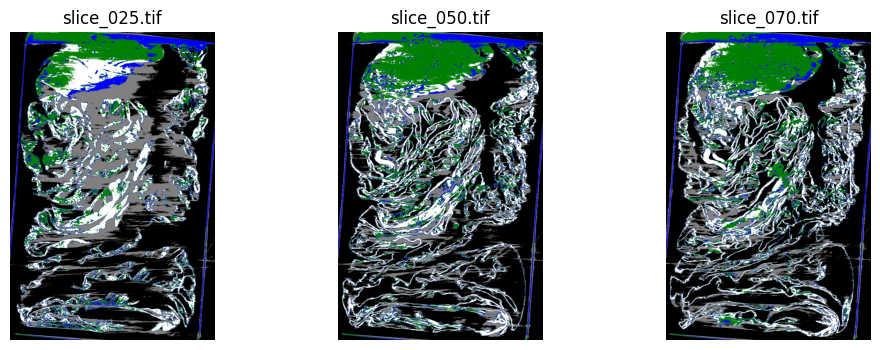

In [ ]:
import matplotlib.pyplot as plt
import tifffile as tiff
from glob import glob

#Displaying some colour-labelled slices

files = sorted(glob(out_folder + "*.tif"))
check_slices = [files[25], files[50], files[70]]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, f in zip(axes, check_slices):
    ax.imshow(tiff.imread(f))
    ax.set_title(os.path.basename(f))
    ax.axis('off')
plt.show()


In [ ]:
import numpy as np
import tifffile as tiff
from glob import glob
import os
import matplotlib.pyplot as plt
import pandas as pd

# === 1️⃣ FOLDER PATH ===
folder = "/content/drive/MyDrive/Placenta_GlobalColorSlices/"   # <-- change this
files = sorted(glob(os.path.join(folder, "*.tif")))
print(f"Found {len(files)} slices")

Found 363 slices


**Integer-labelled segmentation.**

The segmented coloured slices are assigned integer labels. This is essential for volumetric quantification.


Black- Label 0

Grey- Label 1

Blue- Label 2

Green- Label 3

White- Label 4

In [ ]:
import numpy as np
import os
import tifffile as tiff
from glob import glob

src_folder = "/content/drive/MyDrive/Placenta_GlobalColorSlices/"
dst_folder = "/content/drive/MyDrive/Placenta_SegmentedLabels3/"
os.makedirs(dst_folder, exist_ok=True)

files = sorted(glob(os.path.join(src_folder, "*.tif")))
print(f"Found {len(files)} colour slices to convert.")

#Convert Coloured segmented files to Numerical labels
for i, f in enumerate(files):
    rgb = tiff.imread(f).astype(np.int16)
    label_img = np.zeros(rgb.shape[:2], dtype=np.uint8)



    #  White
    mask_white = np.all(rgb > 200, axis=-1)
    label_img[mask_white] = 4

    #  Green
    mask_green = (
        (rgb[..., 1] > 100)
        & (rgb[..., 1] > rgb[..., 0] * 1.3)
        & (rgb[..., 1] > rgb[..., 2] * 1.3)
    )
    label_img[mask_green] = 3

    #  Blue
    mask_blue = (
        (rgb[..., 2] > 120)
        & (rgb[..., 2] > rgb[..., 1] * 1.3)
        & (rgb[..., 2] > rgb[..., 0] * 1.3)
    )
    label_img[mask_blue] = 2

    #  Grey
    mask_gray = (
        (np.abs(rgb[..., 0] - rgb[..., 1]) < 25)
        & (np.abs(rgb[..., 1] - rgb[..., 2]) < 25)
        & (rgb.mean(axis=-1) < 180)
    )
    label_img[mask_gray] = 1


    out_path = os.path.join(dst_folder, f"slice_{i:03d}.tif")
    tiff.imwrite(out_path, label_img.astype(np.uint8))


    if (i + 1) % 50 == 0:
        print(f"Processed {i + 1}/{len(files)} slices")

print("✅ All RGB slices converted to integer-labelled segmentation.")
print("📁 Output folder:", dst_folder)


Found 363 colour slices to convert.
Processed 50/363 slices
Processed 100/363 slices
Processed 150/363 slices
Processed 200/363 slices
Processed 250/363 slices
Processed 300/363 slices
Processed 350/363 slices
✅ All RGB slices converted to integer-labelled segmentation.
📁 Output folder: /content/drive/MyDrive/Placenta_SegmentedLabels3/


**Volumetric Quantification**

This section quantifies the total and relative volumes of each segmented intensity class.

In [ ]:
Segfiles = sorted(glob(os.path.join(dst_folder, "*.tif")))

voxel_counts = {1: 0, 2: 0, 3: 0, 4: 0}
total_voxels = 0

# Loop and Cont voxels per label
for f in Segfiles:
    img = tiff.imread(f)
    total_voxels += img.size


    for label in voxel_counts.keys():
        voxel_counts[label] += np.sum(img == label)

print("✅ Counting complete!")


✅ Counting complete!


In [ ]:
import pandas as pd
voxel_size = (0.086, 0.086, 0.086)
voxel_volume = voxel_size[0] * voxel_size[1] * voxel_size[2]  # mm³ per voxel

data = []
for label, count in voxel_counts.items():
    vol_mm3 = count * voxel_volume
    fraction = (count / total_voxels) * 100
    data.append([label, count, vol_mm3, fraction])

df = pd.DataFrame(data, columns=["Label", "Voxel_count", "Volume_mm3", "Volume_fraction_%"])
print(df)

   Label  Voxel_count    Volume_mm3  Volume_fraction_%
0      1   1855168815  1.179991e+06          78.600934
1      2    119866435  7.624177e+04           5.078575
2      3    182743903  1.162354e+05           7.742606
3      4    202458463  1.287749e+05           8.577885


**Summary of Volumetric Quantification**

The total volume derived from this analysis (**≈ 1501 cm³**) is lower than the value reported by D.Laundon et al. (2024) (**≈ 2148 cm³**).  
However, both results show a **dominant contribution of the outer placental layers**.

- The combined amnion + chorion volumes (≈ 1308 cm³) are comparable to the allantochorion (1412 cm³) reported in the reference study, demonstrating similar overall scale and tissue dominance.  
- Lower-density fluid regions (amniotic and allantoic spaces) are difficult to isolate reliably using global intensity thresholds, leading to under-representation of these volumes.  
- The differences highlight the limitation of intensity-based segmentation, which does not incorporate anatomical context available in machine-learning approaches.

Despite its limitations, this threshold-based segmentation provides a reasonable gross morphometric approximation of the placenta.  
Future work will involve **deep-learning-based segmentation** to improve anatomical accuracy and enable **quantitative 3D vascular and compartmental analysis** consistent with the reference study.




In [ ]:
import pandas as pd

data = {
    "Label": [1, 2, 3, 4],
    "Voxel_count": [1855168815, 119866435, 182743903, 202458463],
    "Volume_mm3": [1.179991e6, 7.624177e4, 1.162354e5, 1.287749e5],
    "Volume_fraction_%": [78.600934, 5.078575, 7.742606, 8.577885]
}


df = pd.DataFrame(data)

df["Volume_cm3"] = df["Volume_mm3"] / 1000


total_mm3 = df["Volume_mm3"].sum()
total_cm3 = df["Volume_cm3"].sum()

print("Placenta Volume Analysis")
print(df)
print("\n🧮 Total Placental Volume:")
print(f"  → {total_mm3:.2f} mm³")
print(f"  → {total_cm3:.2f} cm³")


Placenta Volume Analysis
   Label  Voxel_count  Volume_mm3  Volume_fraction_%  Volume_cm3
0      1   1855168815  1179991.00          78.600934  1179.99100
1      2    119866435    76241.77           5.078575    76.24177
2      3    182743903   116235.40           7.742606   116.23540
3      4    202458463   128774.90           8.577885   128.77490

🧮 Total Placental Volume:
  → 1501243.07 mm³
  → 1501.24 cm³


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**3D volume rendering of coloured placenta**



In [ ]:


import numpy as np
import tifffile as tiff
import plotly.graph_objects as go
from glob import glob
import os

folder = "/content/drive/MyDrive/Placenta_GlobalColorSlices/"
files = sorted(glob(os.path.join(folder, "*.tif"))) [25:30]
print(f"Found {len(files)} slices.")

volume_rgb = np.stack([tiff.imread(f) for f in files]).astype(np.uint8)
print("Stack shape:", volume_rgb.shape)

volume_gray = np.mean(volume_rgb, axis=-1)


z, y, x = np.mgrid[0:volume_gray.shape[0],
                   0:volume_gray.shape[1],
                   0:volume_gray.shape[2]]

# Volume rendering
fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=volume_gray.flatten(),
    opacity=0.08,
    surface_count=20,
    colorscale='Viridis',
))

fig.update_layout(
    scene=dict(aspectmode='data'),
    title="Full 3D Placenta Volume Rendering"
)
fig.show()



Found 5 slices.
Stack shape: (5, 3132, 2076, 3)


****

**LIMITATIONS**

1. The segmentation was based purely on voxel intensity thresholds (Multi-Otsu), which reflects X-ray attenuation rather than explicit anatomical boundaries. As a result, the identified classes represent relative density groups rather than definitive tissue types. Misclassification may occur in regions with overlapping densities.

2. No labelled dataset was used for training or validation. Therefore, segmentation accuracy cannot be quantitatively assessed against biological references.

3. The full-resolution dataset could not be rendered in real-time due to low RAM space on Google colab.


**FUTURE WORK**

1. Future studies will incorporate convolutional neural networks or other deep learning architectures to achieve anatomically accurate segmentation.

2. With access to higher computational resources and increased GPU memory, full-resolution 3D reconstruction of the placental structure will be performed.